# Solving the Hamiltonian Path
## Definition and Purpose

Let $G=(V,E)$ be a graph where $V$ is a set of vertices and $E$ is a set of edges. A Hamiltonian Path is a path in $G$ that visits every vertex exactly once.

Formally, we seek a permutation $P=(v1​,v2​,…,vn​)$ of the vertices in $V$ such that for every adjacent pair of vertices in the sequence, an edge exists in the graph:
$$(vi​,vi+1​)∈E∀1≤i<n$$

No efficient polynomial-time algorithm is known to solve it for general graphs, necessitating the use of metaheuristics for larger instances. Importantly, the Hamiltonian path is critical for de novo genome assembly, where the goal is to reconstruct a single continuous DNA sequence by ordering overlapping fragments (reads) such that each fragment is visited exactly once.

## Strategy and Implementation 

I approach the problem using three metaheuristic approaches: Genetic Algorithms, Simulated Annealing, and Tabu Search. However, the provided course scripts (ga.py, sa.py, tabu.py) are designed for discrete optimisation problems, and standard discrete optimisation operators (bit-flipping, array slicing) are destructive, in the case of permutations (i.e. Hamiltonian path). As such, I have tried to **re-write** the course material scripts in order to better appropriate them for the problem I am trying to solve.

**Swap Mutation** and **Ordered Crossover (OX1)** are introduced later in my scripts to make the algorithms work and score correctly; which are otherwise absent in the original course material scripts.

### Specifically:

- **Generated Graph**: 50 Nodes, 30% edge probability (Erdős-Rényi)
- **Goal**: Minimise the number of "broken" (non-existent) edges in the path. Target Cost = 0

## Setup

Importing course material modules and libraries

In [1]:
import random
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import math
from math import exp, floor

# --- PROBLEM SETUP ---
NUM_NODES = 50
# Use a fixed seed for reproducibility
G = nx.erdos_renyi_graph(n=NUM_NODES, p=0.1, seed=42)
NODES = list(G.nodes)

def get_initial_solution():
    """Returns a random permutation of nodes."""
    p = NODES.copy()
    random.shuffle(p)
    return p

# --- FITNESS FUNCTIONS ---

def count_edges(path):
    """Counts valid edges in the path."""
    edges = 0
    for i in range(len(path) - 1):
        if G.has_edge(path[i], path[i+1]):
            edges += 1
    return edges

# Minimisation Objective (Used by SA & Tabu)
# Lower is better. 0 = Success.
def fitness_min(path):
    target = len(path) - 1
    valid = count_edges(path)
    return float(target - valid)

# Maximisation Objective (Used by GA)
# Higher is better. Target = NUM_NODES - 1
def fitness_max(path):
    return float(count_edges(path))

## Helper Functions (Moves and Neighbourhoods)
Simulated Annealing and Tabu search require a "move" or "neighbourhood" concept, this will help with the permutations.

In [2]:
def random_swap(path):
    """Returns a NEW path with two random nodes swapped (for SA)."""
    new_path = path.copy()
    i, j = random.sample(range(len(path)), 2)
    new_path[i], new_path[j] = new_path[j], new_path[i]
    return new_path

def get_neighborhood(path):
    """
    Returns a list of neighbors for Tabu.
    Instead of just adjacent swaps, we sample 50 random swaps 
    to allow larger jumps across the solution space.
    """
    neighbors = []
    # Generate 50 random neighbors (stochastic hill climbing)
    # This prevents being trapped by the "only adjacent" restriction
    for _ in range(50):
        neighbors.append(random_swap(path))
    return neighbors

## Fitness Functions

As mentioned in the introductory segment, the libraries differ in optimisation direction, so I attempt to implement two versions.

    Goal: A path with N−1 valid edges.

    Minimisation (SA/Tabu): Cost = Number of missing edges. Ideal = 0.

    Maximisation (GA): Fitness = Number of existing edges. Ideal = N−1.

In [3]:
# --- REFINED FITNESS FUNCTIONS ---

def count_edges(path):
    """Counts valid edges in the path."""
    edges = 0
    for i in range(len(path) - 1):
        if G.has_edge(path[i], path[i+1]):
            edges += 1
    return edges

# Minimisation (SA & Tabu): Unchanged
def fitness_min(path):
    target = len(path) - 1
    valid = count_edges(path)
    return float(target - valid)

# Maximisation (GA): LINEAR (Reverted)
# We revert to simple edge counting. Target is NUM_NODES - 1.
def fitness_max(path):
    return float(count_edges(path))

## Simulated Annealing 

In [4]:
def run_simulated_annealing(max_steps=1000, temp0=100.0):
    print("Running Simulated Annealing...")
    
    current = get_initial_solution()
    best = current.copy()
    
    current_cost = fitness_min(current)
    best_cost = current_cost
    
    trace = []
    temp = temp0
    
    for step in range(max_steps):
        # 1. Log Trace
        trace.append(best_cost)
        
        # 2. Stop Condition
        if best_cost == 0:
            print(f"SA Success at step {step}!")
            break
            
        # 3. Create Neighbor (Random Swap)
        neighbor = current.copy()
        i, j = random.sample(range(len(neighbor)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        
        neighbor_cost = fitness_min(neighbor)
        
        # 4. Acceptance Probability
        delta = neighbor_cost - current_cost
        
        if delta < 0 or random.random() < exp(-delta / temp):
            current = neighbor
            current_cost = neighbor_cost
            
            # Update Best
            if current_cost < best_cost:
                best = current.copy()
                best_cost = current_cost
        
        # 5. Cooling (Geometric) - previous runs it failed with 0.99
        temp *= 0.985
        
    return best, trace

## Tabu Search 

In [5]:
def run_tabu_search(max_steps=1000, tenure=20):
    print("Running Tabu Search...")
    
    current = get_initial_solution()
    best = current.copy()
    
    best_cost = fitness_min(best)
    
    tabu_list = []
    trace = []
    
    for step in range(max_steps):
        # 1. Log Trace
        trace.append(best_cost)
        
        # 2. Stop Condition
        if best_cost == 0:
            print(f"Tabu Success at step {step}!")
            break
            
        # 3. Generate Neighborhood (50 Random Swaps)
        # This is 'Stochastic Hill Climbing' within Tabu
        candidates = []
        for _ in range(50):
            candidate = current.copy()
            i, j = random.sample(range(len(candidate)), 2)
            candidate[i], candidate[j] = candidate[j], candidate[i]
            
            # Record move signature (simple tuple of sorted indices) to verify Tabu status
            # Note: For strict Tabu, we usually ban specific moves. 
            # Here we just check if the resulting solution is physically in the list (simplified)
            candidates.append(candidate)
            
        # 4. Select Best Non-Tabu Move
        # Sort by fitness (lowest cost first)
        candidates.sort(key=fitness_min)
        
        found_move = False
        for cand in candidates:
            cand_cost = fitness_min(cand)
            
            # Aspiration Criteria: If it's better than global best, ignore Tabu list
            if cand_cost < best_cost:
                current = cand
                best = cand
                best_cost = cand_cost
                found_move = True
                break
            
            # Otherwise, check Tabu list
            if cand not in tabu_list:
                current = cand
                found_move = True
                break
        
        # 5. Update Tabu List
        if found_move:
            tabu_list.append(current)
            if len(tabu_list) > tenure:
                tabu_list.pop(0)

    return best, trace

## Genetic Algorithm

In [6]:
def run_genetic_algorithm(pop_size=200, generations=1000, cross_rate=0.8, mut_rate=0.3):
    print("Running Genetic Algorithm...")
    
    # ... [Keep your helper operators ordered_crossover and swap_mutation here] ...
    def ordered_crossover(p1, p2):
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end] = p1[start:end]
        current_p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while p2[current_p2_idx] in child:
                    current_p2_idx += 1
                child[i] = p2[current_p2_idx]
        return child

    def swap_mutation(genome):
        i, j = random.sample(range(len(genome)), 2)
        genome[i], genome[j] = genome[j], genome[i]
        return genome
    
    population = [get_initial_solution() for _ in range(pop_size)]
    
    # TRACE NOW STORES TUPLES: (Best Broken, Mean Broken)
    trace = []
    
    target = NUM_NODES - 1
    
    for gen in range(generations):
        # 1. Evaluate
        fitnesses = [fitness_max(p) for p in population]
        best_val = max(fitnesses)
        mean_val = sum(fitnesses) / len(fitnesses) # Calculate Mean
        
        current_broken = target - best_val
        mean_broken = target - mean_val
        
        trace.append((current_broken, mean_broken)) # Store both
        
        if current_broken == 0:
            print(f"GA Success at generation {gen}!")
            break
            
        # ... [Keep Selection, Crossover, Mutation logic same as before] ...
        # 2. Selection
        next_pop = []
        best_idx = fitnesses.index(best_val)
        next_pop.append(population[best_idx])
        while len(next_pop) < pop_size:
            competitors = random.sample(population, 3)
            winner = max(competitors, key=fitness_max)
            next_pop.append(winner)
        population = next_pop

        # 3. Crossover
        for i in range(1, pop_size - 1, 2):
            if random.random() < cross_rate:
                p1 = population[i]
                p2 = population[i+1]
                c1 = ordered_crossover(p1, p2)
                c2 = ordered_crossover(p2, p1)
                population[i] = c1
                population[i+1] = c2
                
        # 4. Mutation
        for i in range(1, pop_size): 
            if random.random() < mut_rate:
                population[i] = swap_mutation(population[i])

    final_fitnesses = [fitness_max(p) for p in population]
    best_idx = final_fitnesses.index(max(final_fitnesses))
    return population[best_idx], trace

## Brute Force (Ground Truth Approach)

Just a quick note for this specific code and the reasoning behind a smaller graph:

- The brute force code solves the Knapsack problem (knapsack.ipynb) by enumerating subsets ($2N$). For $N=21$, that is $2×10^6$ checks (manageable on my M1 Mac)
- If I apply this code directly to the current graph I am testing, the number of solutions I would have to brute force are for $N=50$ (N=number of nodes): $$50!≈3×10^{64}$$
Heat death of the universe! Therefore, I practice the approach on a smaller graph (N=10) to get an approximate idea of the performance compared to the others.

--- VALIDATION TEST (N=10) ---
Brute Force: Checking all permutations for N=10...
Brute Force Result: 6 broken edges.


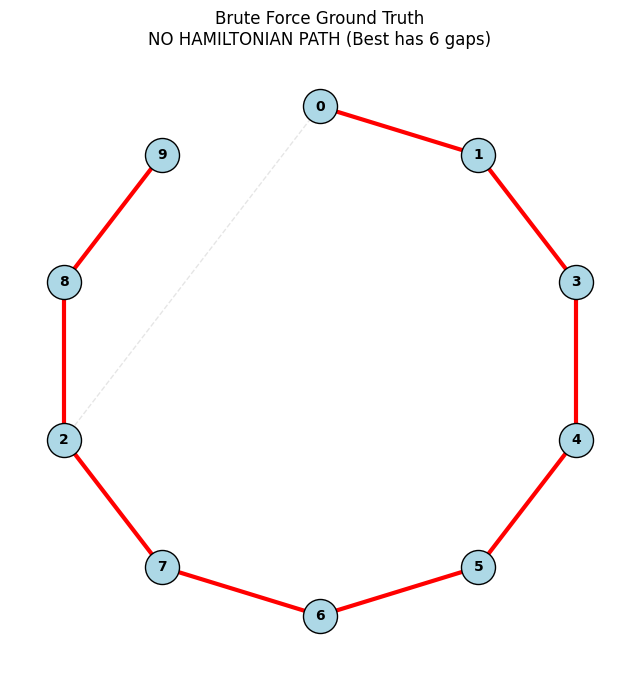

In [7]:
# --- BRUTE FORCE VALIDATION (Small Scale) ---
SMALL_N = 10
G_small = nx.erdos_renyi_graph(n=SMALL_N, p=0.1, seed=999)
small_nodes = list(G_small.nodes)

def brute_force_solver(graph, nodes):
    """
    Generates all permutations to find the Hamiltonian path.
    Returns: (best_path, broken_edges)
    """
    # N=10 is 3.6 million permutations.
    print(f"Brute Force: Checking all permutations for N={len(nodes)}...")
    
    best_path = None
    min_broken = float('inf')
    
    # Iterate through ALL possible permutations
    for path in itertools.permutations(nodes):
        broken = 0
        # Calculate broken edges
        for i in range(len(path) - 1):
            if not graph.has_edge(path[i], path[i+1]):
                broken += 1
                # Pruning: stop if this path is already worse than our best
                if broken >= min_broken:
                    break
        
        if broken < min_broken:
            min_broken = broken
            best_path = path
            if min_broken == 0: 
                break # Perfect solution found
                
    return best_path, min_broken

# 1. Run Solver
print(f"--- VALIDATION TEST (N={SMALL_N}) ---")
bf_path, bf_score = brute_force_solver(G_small, small_nodes)
print(f"Brute Force Result: {bf_score} broken edges.")

# 2. Visualise Result
if bf_path:
    plt.figure(figsize=(8, 8))
    
    # Custom Layout: Order nodes in a circle based on the FOUND path
    pos_bf = {}
    N = len(bf_path)
    for i, node in enumerate(bf_path):
        angle = -2 * math.pi * i / N + math.pi/2 # Clockwise, starting top
        pos_bf[node] = (math.cos(angle), math.sin(angle))
        
    # Draw Background Edges (Grey dashed)
    path_edges_set = set()
    for i in range(len(bf_path)-1):
        path_edges_set.add(tuple(sorted((bf_path[i], bf_path[i+1]))))
    
    non_path_edges = [
        (u, v) for u, v in G_small.edges() 
        if tuple(sorted((u, v))) not in path_edges_set
    ]
    
    nx.draw_networkx_edges(G_small, pos_bf, edgelist=non_path_edges, 
                          alpha=0.2, edge_color='grey', style='dashed')
    
    # Draw Nodes
    nx.draw_networkx_nodes(G_small, pos_bf, node_size=600, 
                          node_color='lightblue', edgecolors='black')
    
    # Draw Solution Path (Red)
    path_edges = [(bf_path[i], bf_path[i+1]) for i in range(len(bf_path)-1)]
    nx.draw_networkx_edges(G_small, pos_bf, edgelist=path_edges, 
                          edge_color='red', width=3)
    
    # Labels
    nx.draw_networkx_labels(G_small, pos_bf, font_size=10, font_weight='bold')
    
    title = "Brute Force Ground Truth\n"
    title += "PERFECT PATH FOUND" if bf_score == 0 else f"NO HAMILTONIAN PATH (Best has {bf_score} gaps)"
    plt.title(title)
    plt.axis('off')
    plt.show()

## Visualise

Running Simulated Annealing...
Running Tabu Search...
Running Genetic Algorithm...


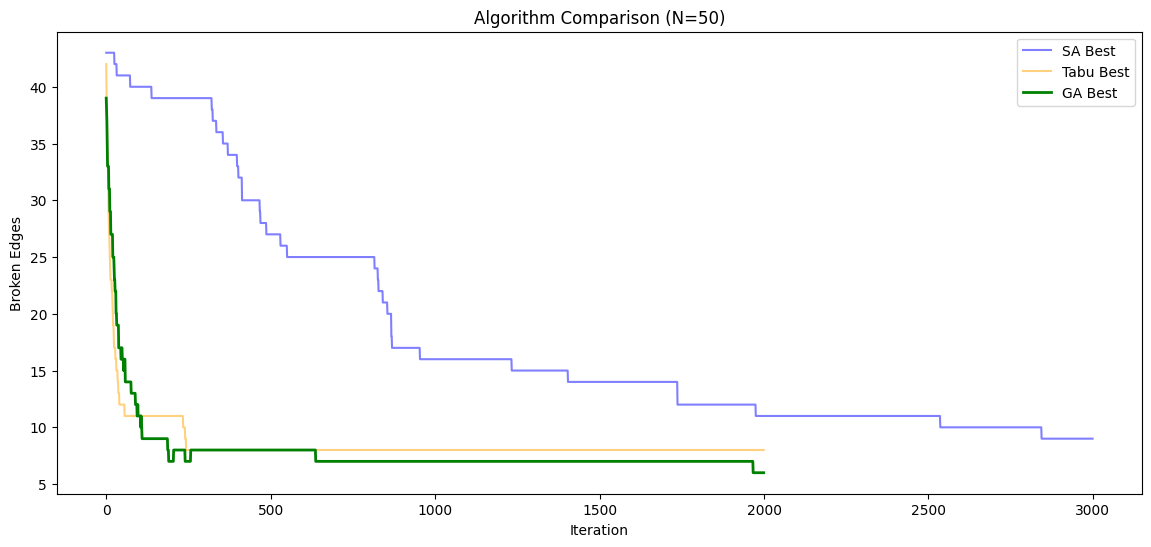

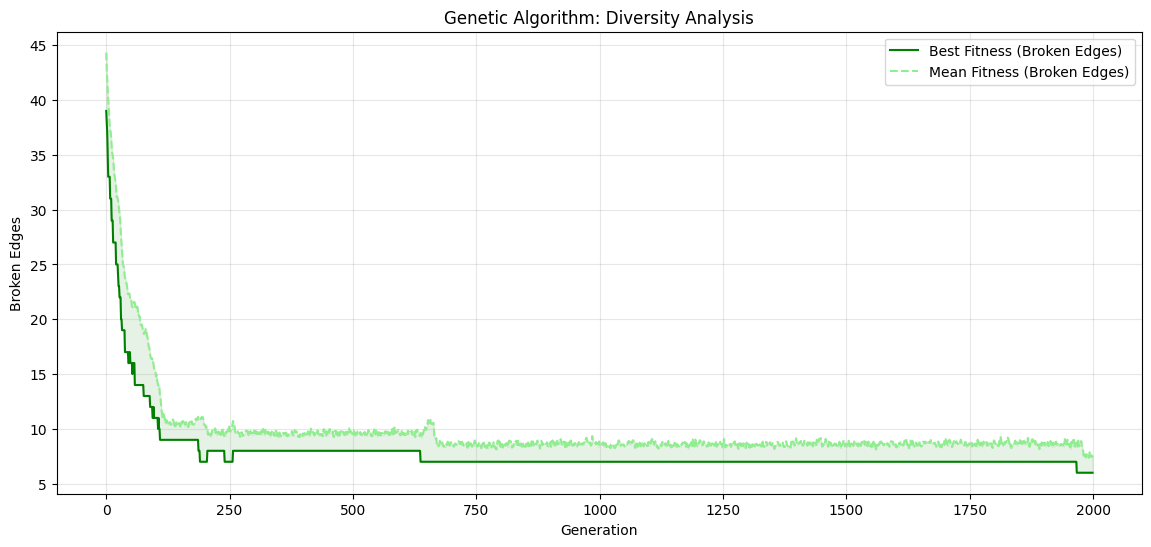

Note: If the Mean curve converges to the Best curve too early (gap closes), the population has lost diversity.


,Algorithm,Success,Final Broken Edges,Iterations to Best
0,Simulated Annealing,False,9,3000
1,Tabu Search,False,8,2000
2,Genetic Algorithm,False,6,2000


In [8]:
# --- EXECUTION ---
# 1. SA
best_sa, trace_sa = run_simulated_annealing(max_steps=3000) # Rather saccusful parameters; stochasticity might induce issues (1 broken edge remaining)
# 2. Tabu
best_tabu, trace_tabu = run_tabu_search(max_steps=2000, tenure=30) # Succesful parameters
# 3. GA
best_ga, trace_ga = run_genetic_algorithm(generations=2000, pop_size=200, mut_rate=0.4) # Succesful parameters


# --- PLOT 1: Algorithm Comparison (Standard) ---
plt.figure(figsize=(14, 6))
# Extract just the "Best" value (index 0) from GA trace for comparison
ga_best_trace = [t[0] for t in trace_ga]

plt.plot(trace_sa, label='SA Best', color='blue', alpha=0.5)
plt.plot(trace_tabu, label='Tabu Best', color='orange', alpha=0.5)
plt.plot(ga_best_trace, label='GA Best', color='green', linewidth=2)
plt.title(f"Algorithm Comparison (N={NUM_NODES})")
plt.xlabel("Iteration")
plt.ylabel("Broken Edges")
plt.legend()
plt.show()

# --- PLOT 2: GA Diversity Analysis (Teacher's Style) ---
plt.figure(figsize=(14, 6))
plt.plot([t[0] for t in trace_ga], label='Best Fitness (Broken Edges)', color='green')
plt.plot([t[1] for t in trace_ga], label='Mean Fitness (Broken Edges)', color='lightgreen', linestyle='--')

plt.fill_between(range(len(trace_ga)), 
                 [t[0] for t in trace_ga], 
                 [t[1] for t in trace_ga], 
                 color='green', alpha=0.1)

plt.title("Genetic Algorithm: Diversity Analysis")
plt.xlabel("Generation")
plt.ylabel("Broken Edges")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Note: If the Mean curve converges to the Best curve too early (gap closes), the population has lost diversity.")

# --- 3. RESULTS TABLE ---
results_data = {
    "Algorithm": ["Simulated Annealing", "Tabu Search", "Genetic Algorithm"],
    "Success": [trace_sa[-1] == 0, trace_tabu[-1] == 0, trace_ga[-1][0] == 0],
    # FIX: trace_ga[-1] is a tuple (best, mean), so we take [0] for the best score
    "Final Broken Edges": [int(trace_sa[-1]), int(trace_tabu[-1]), int(trace_ga[-1][0])],
    "Iterations to Best": [len(trace_sa), len(trace_tabu), len(trace_ga)]
}
df_results = pd.DataFrame(results_data)
display(df_results)

# --- 4. VISUALISING THE BEST PATH ---
successful_path = None
# Check for success (Cost 0 for SA/Tabu, or Edges = N-1 for GA)
if fitness_min(best_tabu) == 0: successful_path = best_tabu
elif fitness_min(best_sa) == 0: successful_path = best_sa
elif count_edges(best_ga) == (NUM_NODES - 1): successful_path = best_ga

try:
    from pyvis.network import Network
    import networkx as nx

    if successful_path:
        # Create a Pyvis network
        net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")
        net.repulsion(node_distance=300, spring_length=200)
        # 1. Add all nodes and background edges first
        # We iterate G edges. If it's in the path, we skip (to add it later with color)
        path_pairs = []
        for i in range(len(successful_path)-1):
            u, v = successful_path[i], successful_path[i+1]
            path_pairs.append(tuple(sorted((u, v))))
            
        for u, v in G.edges():
            if tuple(sorted((u, v))) not in path_pairs:
                net.add_node(u, label=str(u), color='#444444')
                net.add_node(v, label=str(v), color='#444444')
                net.add_edge(u, v, color='#333333', width=1) # Dark grey background
        
        # 2. Add Path Edges (Red)
        for i in range(len(successful_path)-1):
            u = successful_path[i]
            v = successful_path[i+1]
            # Nodes might already exist, update them or re-add
            net.add_node(u, color='red', title=f"Index {i}")
            net.add_node(v, color='red')
            net.add_edge(u, v, color='red', width=4, label=str(i+1))

        # 3. Settings for physics (force atlas is good for separation)
        net.toggle_physics(False)
        net.show_buttons(filter_=['physics'])
        # Place this before net.show()
        net.show("hamiltonian_path.html")
        print("Graph saved to hamiltonian_path.html")
        
except ImportError:
    print("Pyvis not installed. Please run 'pip install pyvis' locally.")